In [1]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

Using TensorFlow backend.


In [2]:
IMAGE_SIZE = [224, 224]

In [3]:
epochs = 16
batch_size = 32

In [4]:
train_path = 'C:\\Users\\ABindal2\\Research\\Practice\\Advanced Deep Learning\\ResNet-50\\TRAIN'
valid_path = 'C:\\Users\\ABindal2\\Research\\Practice\\Advanced Deep Learning\\ResNet-50\\TEST'

In [5]:
image_files = glob(train_path + '/*/*.jpeg')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [6]:
folders = glob(train_path + '/*')

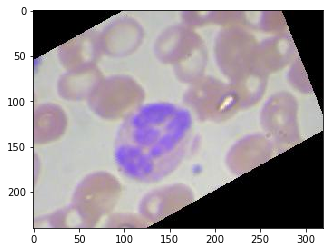

In [7]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [8]:
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

c:\users\abindal2\appdata\local\programs\python\python37\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [9]:
for layer in res.layers:
    layer.trainable = False

In [10]:
x = Flatten()(res.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=res.input, outputs=prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [11]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [12]:
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [13]:
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.68 max: 148.59998


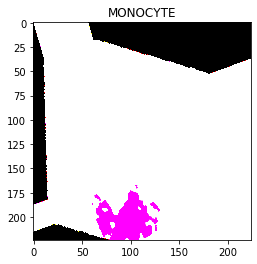

In [14]:
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [15]:
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [16]:
len(valid_image_files) // batch_size

77

In [23]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/16
311/311 [==============================] - 1905s 6s/step - loss: 2.5640 - accuracy: 0.9041 - val_loss: 38.9436 - val_accuracy: 0.4119
Epoch 2/16
311/311 [==============================] - 1926s 6s/step - loss: 2.6707 - accuracy: 0.9056 - val_loss: 95.9072 - val_accuracy: 0.3695
Epoch 3/16
311/311 [==============================] - 1893s 6s/step - loss: 2.5014 - accuracy: 0.9093 - val_loss: 49.0056 - val_accuracy: 0.3857
Epoch 4/16
311/311 [==============================] - 1920s 6s/step - loss: 2.6454 - accuracy: 0.9069 - val_loss: 65.4051 - val_accuracy: 0.3141
Epoch 5/16
311/311 [==============================] - 1891s 6s/step - loss: 2.5460 - accuracy: 0.9114 - val_loss: 86.4558 - val_accuracy: 0.4004
Epoch 6/16
311/311 [==============================] - 1911s 6s/step - loss: 2.5434 - accuracy: 0.9122 - val_loss: 63.7586 - val_accuracy: 0.3967
Epoch 7/16
311/311 [==============================] - 1918s 6s/step - loss: 2.3837 - accuracy: 0.9175 - val_loss: 45.2941 - val_ac

In [24]:
def get_confusion_matrix(data_path, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [25]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
50
100
150
[[ 227  897 1234  139]
 [   9 1834  611   29]
 [   2  465 2001   10]
 [  54  746 1206  493]]
Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
[[ 24 262 263  74]
 [  5 388 223   4]
 [  4 120 465  31]
 [ 18 223 280 103]]


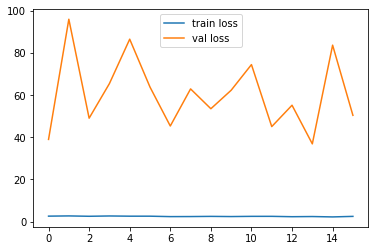

In [26]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

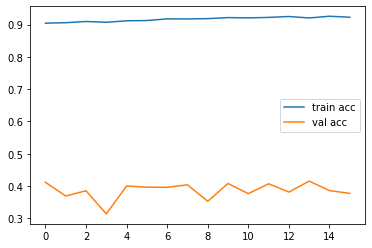

In [27]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()